In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter

import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple, name_data
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle
from filters import filter_butter
from fast_open_data import open_data_filter

# -> Escolher voluntário e chave

* open_data_filter(Voluntary => 1 até 90, key => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2' ...)

In [2]:
S, L, R = open_data_filter(52, key = 'S1_Synched')

In [3]:
# dados para voluntário 52
estimated_R = [ 30, 350, 555, 870]
estimated_L = [ 80, 370, 570, 830]
estimated_S = [ 140, 264, 365, 570, 647, 865]

sequece_R_L = [1,2,1,3,1]
sequece_S = [1,2,3,1,2,3,1]

In [4]:
sequence = sequece_S.copy()
sequence.extend(sequece_R_L) 
classes = np.unique(sequence)

In [5]:
def sep_modo(data, estimated_data, modo_sequence, classes):
    
    
    V_seq = np.zeros(len(modo_sequence))
    V_modo = np.zeros(len(classes))
    
    modo = np.zeros((data.shape))

    for i in range(len(modo_sequence)):
        if i == 0:
            modo[:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[:estimated_data[i]]))
            
            
        elif i == (len(estimated_data)):
            modo[estimated_data[i-1]:] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:]))
        
        else:
            modo[estimated_data[i-1]:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:estimated_data[i]]))
                    
    for n in range(len(classes)):
        idx = np.where(np.array(modo_sequence) == n+1)[0]
        V_modo[n] = np.mean(np.array(V_seq)[idx])
        
    return modo, V_seq, V_modo
            

In [6]:
modo, V_seq, V_modo = sep_modo(S, estimated_S, sequece_S, classes)

O sinal do movimento está na escala de 0 à 3 para facilitar a visualização dos modos em relação ao sinal.

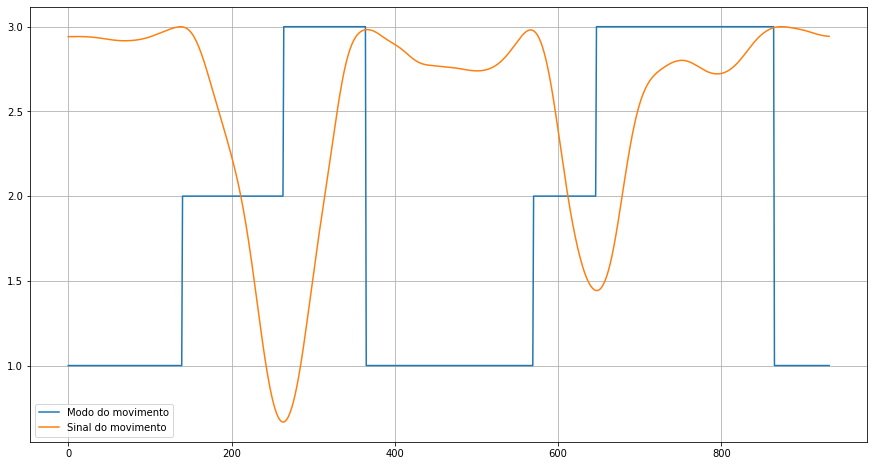

In [7]:
plt.figure(figsize=[15,8])
plt.plot(modo, label = 'Modo do movimento')
plt.plot(S/max(S)*3, label = 'Sinal do movimento')
plt.legend()
plt.grid()
plt.show()

In [8]:
for i in range(len(V_seq)):
    print('Modo: ', sequece_S[i], '--> Velocidade: ', round(V_seq[i], 4))

Modo:  1 --> Velocidade:  0.0117
Modo:  2 --> Velocidade:  -0.5316
Modo:  3 --> Velocidade:  0.649
Modo:  1 --> Velocidade:  -0.0006
Modo:  2 --> Velocidade:  -0.5651
Modo:  3 --> Velocidade:  0.2004
Modo:  1 --> Velocidade:  -0.0217


Aplicando as médias para cada uma das fases dos movimentos, temos que: 

In [9]:
for i in range(len(V_modo)):
    print('Modo: ', classes[i], '--> Velocidade: ', round(V_modo[i], 4))

Modo:  1 --> Velocidade:  -0.0035
Modo:  2 --> Velocidade:  -0.5484
Modo:  3 --> Velocidade:  0.4247


In [10]:
def generate_model(data, modo, V_modo):
    
    data_model = np.zeros(S.shape)
    for i in range(len(data)):
        if i == 0:
            data_model[i] = data[i]
        else:
            data_model[i] = data[i-1] + V_modo[int(modo[i])-1]
    
    return data_model

In [11]:
data_model = generate_model(S, modo, V_modo)

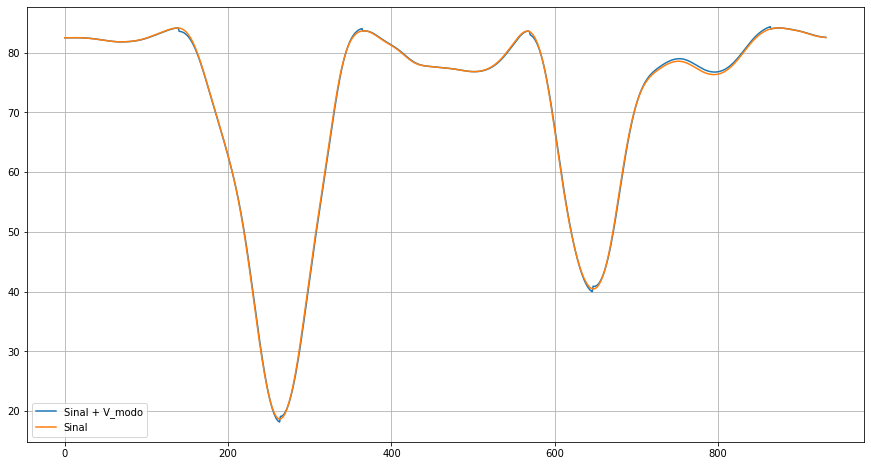

In [12]:
plt.figure(figsize=[15,8])
plt.plot(data_model, label = 'Sinal + V_modo')
plt.plot(S, label = 'Sinal')
plt.legend()
plt.grid()
plt.show()